In [4]:
%matplotlib inline
from alpha_vantage.timeseries import TimeSeries
from alpha_vantage.techindicators import TechIndicators
from alpha_vantage.sectorperformance import SectorPerformances
from alpha_vantage.cryptocurrencies import CryptoCurrencies
import json
import http
conec = http.client.HTTPSConnection('www.alphavantage.co', timeout = 10)
conec.request("GET", '/query?function=TIME_SERIES_WEEKLY&symbol=MSFT&interval=5min&apikey=07THEOFGYUDV073A')
resp=conec.getresponse()
jro = json.loads(resp.read().decode('utf8'))
#for k, v in jro['Monthly Time Series'].items():
    #print('Event at time ' + k)
    #print(v)
#print(jro['Time Series (5min)']['2019-10-16 20:00:00']['3. low'])


#for trainning
from pandas_datareader import data
import matplotlib.pyplot as plt
import matplotlib
import pandas as pd
import keras
from keras.models import Sequential
from keras.layers import Dense, Convolution1D, Flatten, MaxPooling1D
import datetime as dt
import urllib.request, json
import os
import numpy as np
#import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler

# variables: '1. open', '2. high', '3. low', '4. close'
# Make plots bigger
matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)

"""HIGH DATA and LOW DATA"""
k=0
mid=[]
test=[]
for timestamp, data in jro['Weekly Time Series'].items():
    high = float(data['2. high'])
    low = float(data['3. low'])
    close=float(data['4. close'])
    midpoint = (high+low)/2.0
    mid.insert(0, close)
    #print(timestamp) -> from 2019 to begining
    #]\\print(test)
"""............................................."""
"""OPEN STOCK """
#for timestamp, data in jro['Monthly Time Series'].items():
#    openn=float(data['1. open'])
#    #print(openn)
"""CLOSE STOCK"""
#for timestamp, data in jro['Monthly Time Series'].items():
#    close=float(data['4. close'])
#    #print(close)

"""""""""

scaler = MinMaxScaler()

training_data = np.array(mid).reshape(-1,1)
testing_data = np.array(test).reshape(-1,1)
#print(train_reshape[di:di+smoothing_window_size,:])
smoothing_window_size = 50
for di in range(0,100,smoothing_window_size):
    scaler.fit(training_data[di:di+smoothing_window_size,:])
    training_data[di:di+smoothing_window_size,:] = scaler.transform(training_data[di:di+smoothing_window_size,:])


scaler.fit(training_data[di+smoothing_window_size:,:])
training_data[di+smoothing_window_size:,:] = scaler.transform(training_data[di+smoothing_window_size:,:])

training_data = training_data.reshape(-1)
testing_data = scaler.transform(testing_data).reshape(-1)

y_train=[]

EMA = 0.0
gamma = 0.1
for ti in range(200):
  EMA = gamma*training_data[ti] + (1-gamma)*EMA
  training_data[ti] = EMA
all_mid_data = np.concatenate([training_data, testing_data], axis=0)
classifier=Sequential()
classifier.add(Conv1D(32, (3), input_shape=(4,1), activation='relu'))
classifier.add(Flatten())
classifier.add(Dense(64, activation='softmax'))
classifier.add(Dense(training_data, activation='softmax'))
classifier.compile(loss=keras.losses.categorical_crossentropy,optimizer=keras.optimizer.Adadelta(),metrics = ["accuracy"])
classifier.summary()
batch_size = 128
epochs = 10
classifier.fit(training_data, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(training_data, y_train))
#x=classifier.fit(training_data, y_train, epochs=200, verbose=1)
print(type(training_data))
"""""""""
def make_timeseries_regressor(window_size, filter_length, nb_input_series=1, nb_outputs=1, nb_filter=4):
    model = Sequential((
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu', input_shape=(window_size, nb_input_series)),
        MaxPooling1D(),
        Convolution1D(nb_filter=nb_filter, filter_length=filter_length, activation='relu'),
        MaxPooling1D(),
        Flatten(),
        Dense(nb_outputs, activation='linear'),
    ))
    model.compile(loss='mse', optimizer='adam', metrics=['mae'])
    return model


def make_timeseries_instances(timeseries, window_size):
    timeseries = np.asarray(timeseries)
    assert 0 < window_size < timeseries.shape[0]
    X = np.atleast_3d(np.array([timeseries[start:start + window_size] for start in range(0, timeseries.shape[0] - window_size)]))
    y = timeseries[window_size:]
    q = np.atleast_3d([timeseries[-window_size:]])
    return X, y, q


def evaluate_timeseries(timeseries, window_size):
    filter_length = 5
    nb_filter = 4
    timeseries = np.atleast_2d(timeseries)
    if timeseries.shape[0] == 1:
        timeseries = timeseries.T       #1D vectors -> 2D column vectors

    nb_samples, nb_series = timeseries.shape
    model = make_timeseries_regressor(window_size=window_size, filter_length=filter_length, nb_input_series=nb_series, nb_outputs=nb_series, nb_filter=nb_filter)

    model.summary()

    X, y, q = make_timeseries_instances(timeseries, window_size)
    test_size = int(0.2 * nb_samples)
    X_train, X_test, y_train, y_test = X[:-test_size], X[-test_size:], y[:-test_size], y[-test_size:]
    model.fit(X_train, y_train, nb_epoch=25, batch_size=2, validation_data=(X_test, y_test))

    print(type(model))
    pred = model.predict(X_test)
    print('\n\nactual', 'predicted', sep='\t')
    for actual, predicted in zip(y_test, pred.squeeze()):
        print(actual.squeeze(), predicted, sep='\t')
    print('next', model.predict(q).squeeze(), sep='\t')

#def company()
def main():
    """Prepare input data, build model, evaluate."""
    np.set_printoptions(threshold=25)
    ts_length = len(jro['Weekly Time Series'].items())
    window_size = int(0.2*(ts_length))

    print('\nSimple single timeseries vector prediction')
    timeseries = np.arange(ts_length)                   # The timeseries f(t) = t
    evaluate_timeseries(mid, window_size)

    print('\nMultiple-input, multiple-output prediction')
    timeseries = np.array([np.arange(ts_length), -np.arange(ts_length)]).T      # The timeseries f(t) = [t, -t]
    evaluate_timeseries(mid, window_size)
    
main()


Simple single timeseries vector prediction


Timeseries (1044 samples by 1 series):
 [[ 91.563]
 [ 89.188]
 [ 86.   ]
 ...
 [137.41 ]
 [140.73 ]
 [144.42 ]]


C:\Users\Radu\Anaconda3\lib\site-packages\ipykernel_launcher.py:105: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", input_shape=(208, 1), filters=4, kernel_size=5)`
C:\Users\Radu\Anaconda3\lib\site-packages\ipykernel_launcher.py:107: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(activation="relu", filters=4, kernel_size=5)`


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_9 (Conv1D)            (None, 204, 4)            24        
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 102, 4)            0         
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 98, 4)             84        
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 49, 4)             0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 196)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 197       
Total params: 305
Trainable params: 305
Non-trainable params: 0
_________________________________________________________________


C:\Users\Radu\Anaconda3\lib\site-packages\ipykernel_launcher.py:142: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 628 samples, validate on 208 samples
Epoch 1/25
628/628 [==============================] - 3s 5ms/step - loss: 66.6370 - mean_absolute_error: 6.1230 - val_loss: 213.8150 - val_mean_absolute_error: 12.1245
Epoch 2/25
628/628 [==============================] - 2s 4ms/step - loss: 20.1908 - mean_absolute_error: 3.4416 - val_loss: 108.6276 - val_mean_absolute_error: 8.5065
Epoch 3/25
628/628 [==============================] - 2s 4ms/step - loss: 15.4052 - mean_absolute_error: 3.1208 - val_loss: 48.3635 - val_mean_absolute_error: 5.5311
Epoch 4/25
628/628 [==============================] - 3s 4ms/step - loss: 12.4576 - mean_absolute_error: 2.8193 - val_loss: 84.3203 - val_mean_absolute_error: 7.6272
Epoch 5/25
628/628 [==============================] - 3s 4ms/step - loss: 10.4912 - mean_absolute_error: 2.5532 - val_loss: 37.6430 - val_mean_absolute_error: 4.9559
Epoch 6/25
628/628 [==============================] - 2s 4ms/step - loss: 9.9965 - mean_absolute_error: 2.4887 - val_loss

Train on 628 samples, validate on 208 samples
Epoch 1/25
628/628 [==============================] - 3s 5ms/step - loss: 45.9561 - mean_absolute_error: 4.8628 - val_loss: 35.5363 - val_mean_absolute_error: 4.8690
Epoch 2/25
628/628 [==============================] - 2s 3ms/step - loss: 16.9579 - mean_absolute_error: 3.2733 - val_loss: 63.0392 - val_mean_absolute_error: 6.5621
Epoch 3/25
628/628 [==============================] - 2s 4ms/step - loss: 14.4323 - mean_absolute_error: 3.0204 - val_loss: 45.6190 - val_mean_absolute_error: 5.5219
Epoch 4/25
628/628 [==============================] - 2s 4ms/step - loss: 11.3756 - mean_absolute_error: 2.5944 - val_loss: 60.4603 - val_mean_absolute_error: 6.4728
Epoch 5/25
628/628 [==============================] - 2s 4ms/step - loss: 10.7804 - mean_absolute_error: 2.5516 - val_loss: 25.7635 - val_mean_absolute_error: 3.9848
Epoch 6/25
628/628 [==============================] - 2s 4ms/step - loss: 9.3719 - mean_absolute_error: 2.4010 - val_loss: 5

<class 'pandas.core.frame.DataFrame'>


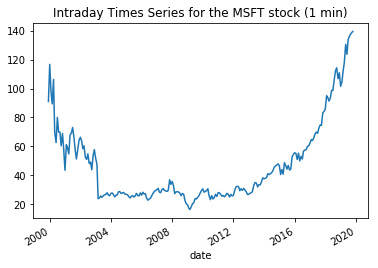

In [5]:
#ts = TimeSeries(key='07THEOFGYUDV073A', output_format='pandas')

window_size=100
N=training_data.size
avg_predictions=[]
avg_x=[]
for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = jro.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = jro.loc[pred_idx,'']

    avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((avg_predictions[-1]-training_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE predic %.5f'%(0.5*np.mean(mse_errors)))






In [4]:
#EMA = 0.0
#gamma = 0.1
#for ti in range(11000):
 # EMA = gamma*train_reshape[ti] + (1-gamma)*EMA
  #train_reshape[ti] = EMA